# Model `ELBMF`

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
# from models.bmf_elbmf_fujiwara.mylib.elbmf import ELBMF

# sys.path.append('../models/bmf_elbmf_fujiwara/mylib/')
# from elbmf import ELBMF

sys.path.append('../models/')
from ELBMFNumPy import ELBMF

In [3]:
# from generators import BlockDiagonalMatrixGenerator

# data = BlockDiagonalMatrixGenerator(m=300, n=500, k=15, overlap=[0.3, 0.3])
# data.generate(seed=1997)

# data.add_noise(noise=[0.4, 0.1], seed=2000)
# data.show_matrix()

In [4]:
from datasets import MovieLensData

data = MovieLensData(size="100k")
data.load()

idx = data.sample(factor_id=0, n_samples=300, seed=1000)
idx = data.sample(factor_id=1, n_samples=500, seed=1000)

[I] Sampling axis 0 to size 300
[I]   sampling seed: 1000
[I]   sampling from: (943, 1682)
[I]   sampling to  : (300, 1682)
[I] Sampling axis 1 to size 500
[I]   sampling seed: 1000
[I]   sampling from: (300, 1682)
[I]   sampling to  : (300, 500)


In [5]:
from datasets import RatioSplit, NoSplit

# split = RatioSplit(X=data.X, val_size=0.1, test_size=0.2, seed=1997)
# split.negative_sample(
#     train_size=split.pos_train_size, 
#     val_size=split.pos_val_size, 
#     test_size=split.pos_test_size, 
#     seed=2023, type='popularity')

split = NoSplit(X=data.X)

# split.negative_sample(size=split.pos_size, type="popularity", seed=2023)

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

[I] NoSplit, sampling positives
[I] RatioSplit, sampling positives
[I]   seed         : 1720968950
[I]   train_size   : 10754
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 1720968950


# 1 Init U, V with `NMFSklearn` / `WNMF`

In [6]:
# from models import NMFSklearn, WNMF
# from utils import show_factor_distribution

# k = 100

# model_nmf = NMFSklearn(k=k, init_method='nndsvd', max_iter=1000, seed=2024)
# # model_nmf = WNMF(k=k, W='full', beta_loss='frobenius', init_method='normal', max_iter=1000, seed=2024)

# model_nmf.fit(X_train=X_train, task='reconstruction', verbose=False, display=False)

# # show_factor_distribution(U=model_nmf.U, V=model_nmf.V, resolution=100)

# 2. `ELBMF`

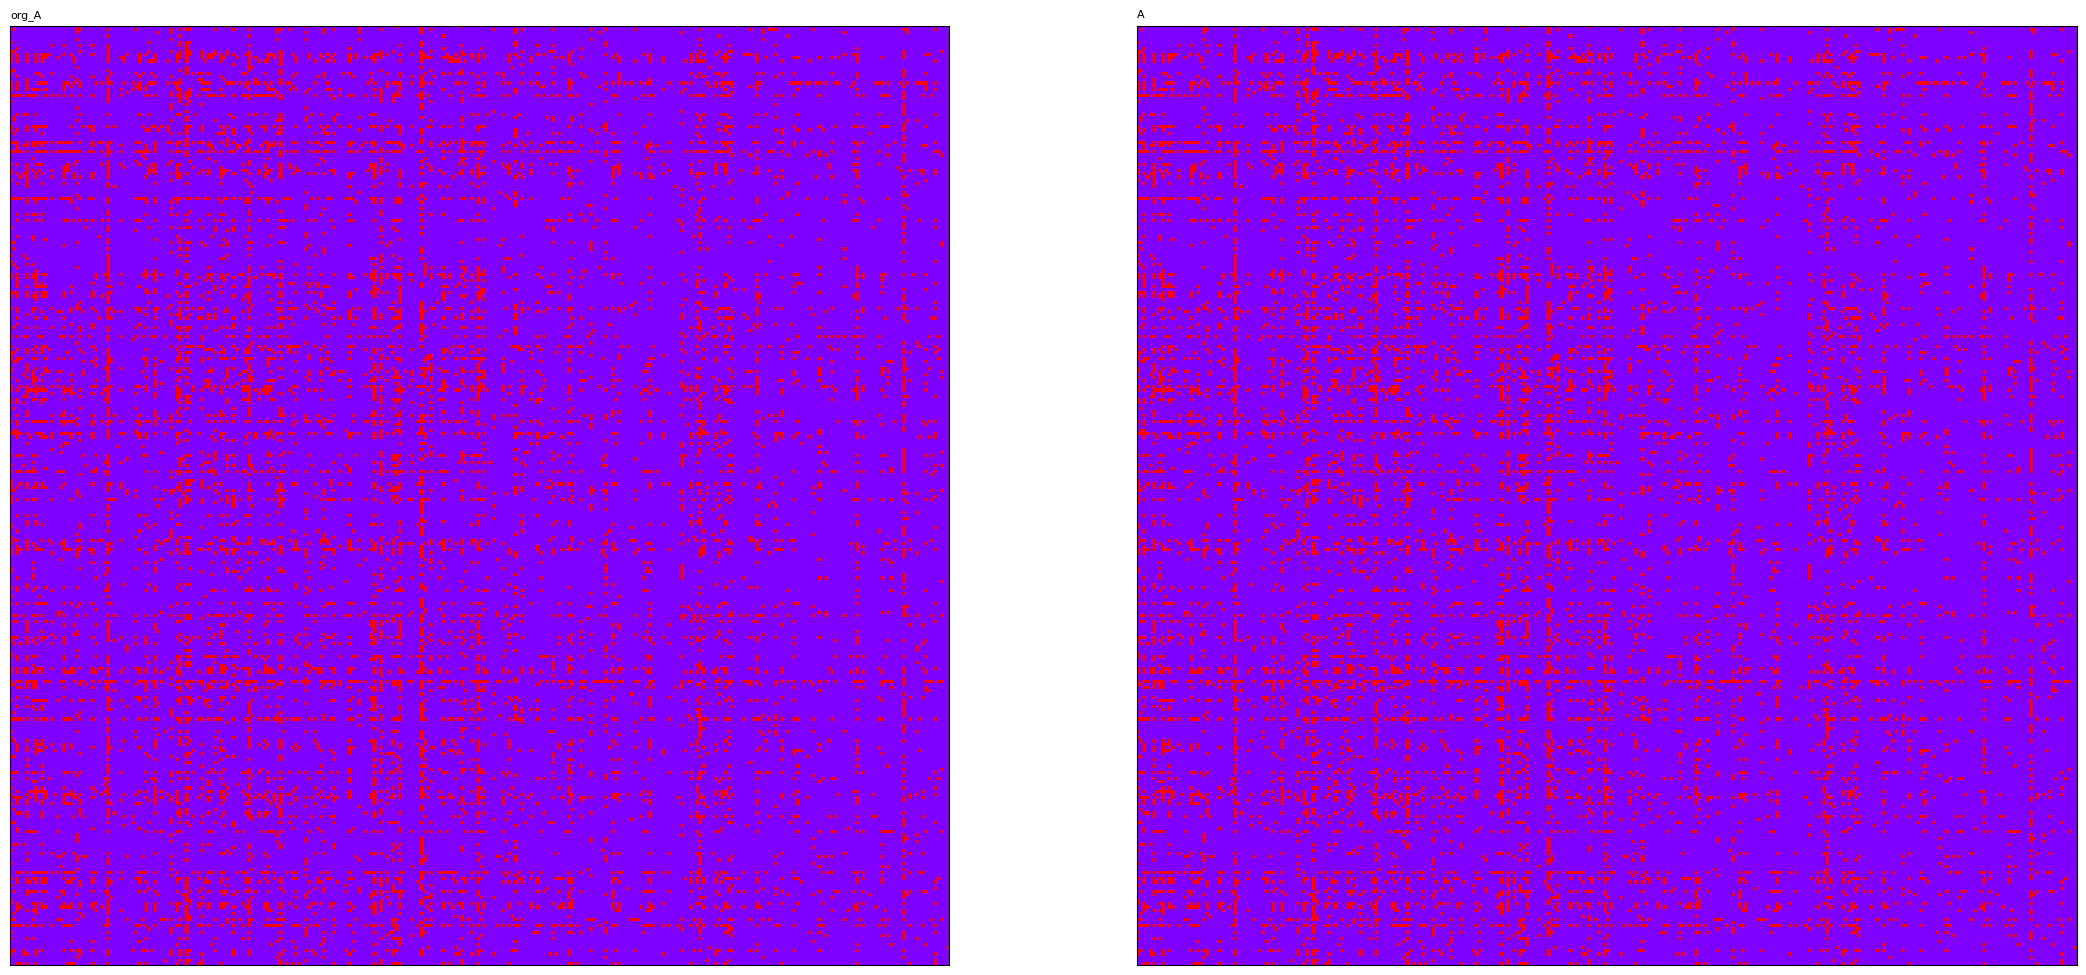

<Figure size 640x480 with 0 Axes>

In [7]:
# from utils import show_matrix, to_dense

# org_A = to_dense(X_train[:, :300])
# A = to_dense(X_train[:, :300])

# show_matrix([(org_A, [0, 0], 'org_A'), (A, [0, 1], 'A')])

init_loss
recall : 1.0, similarity : 0.9025777777777778, relative loss : 712242176.0
result_loss
recall : 0.2542198905109489, similarity : 0.0855888888888889, relative loss : 67539904.0


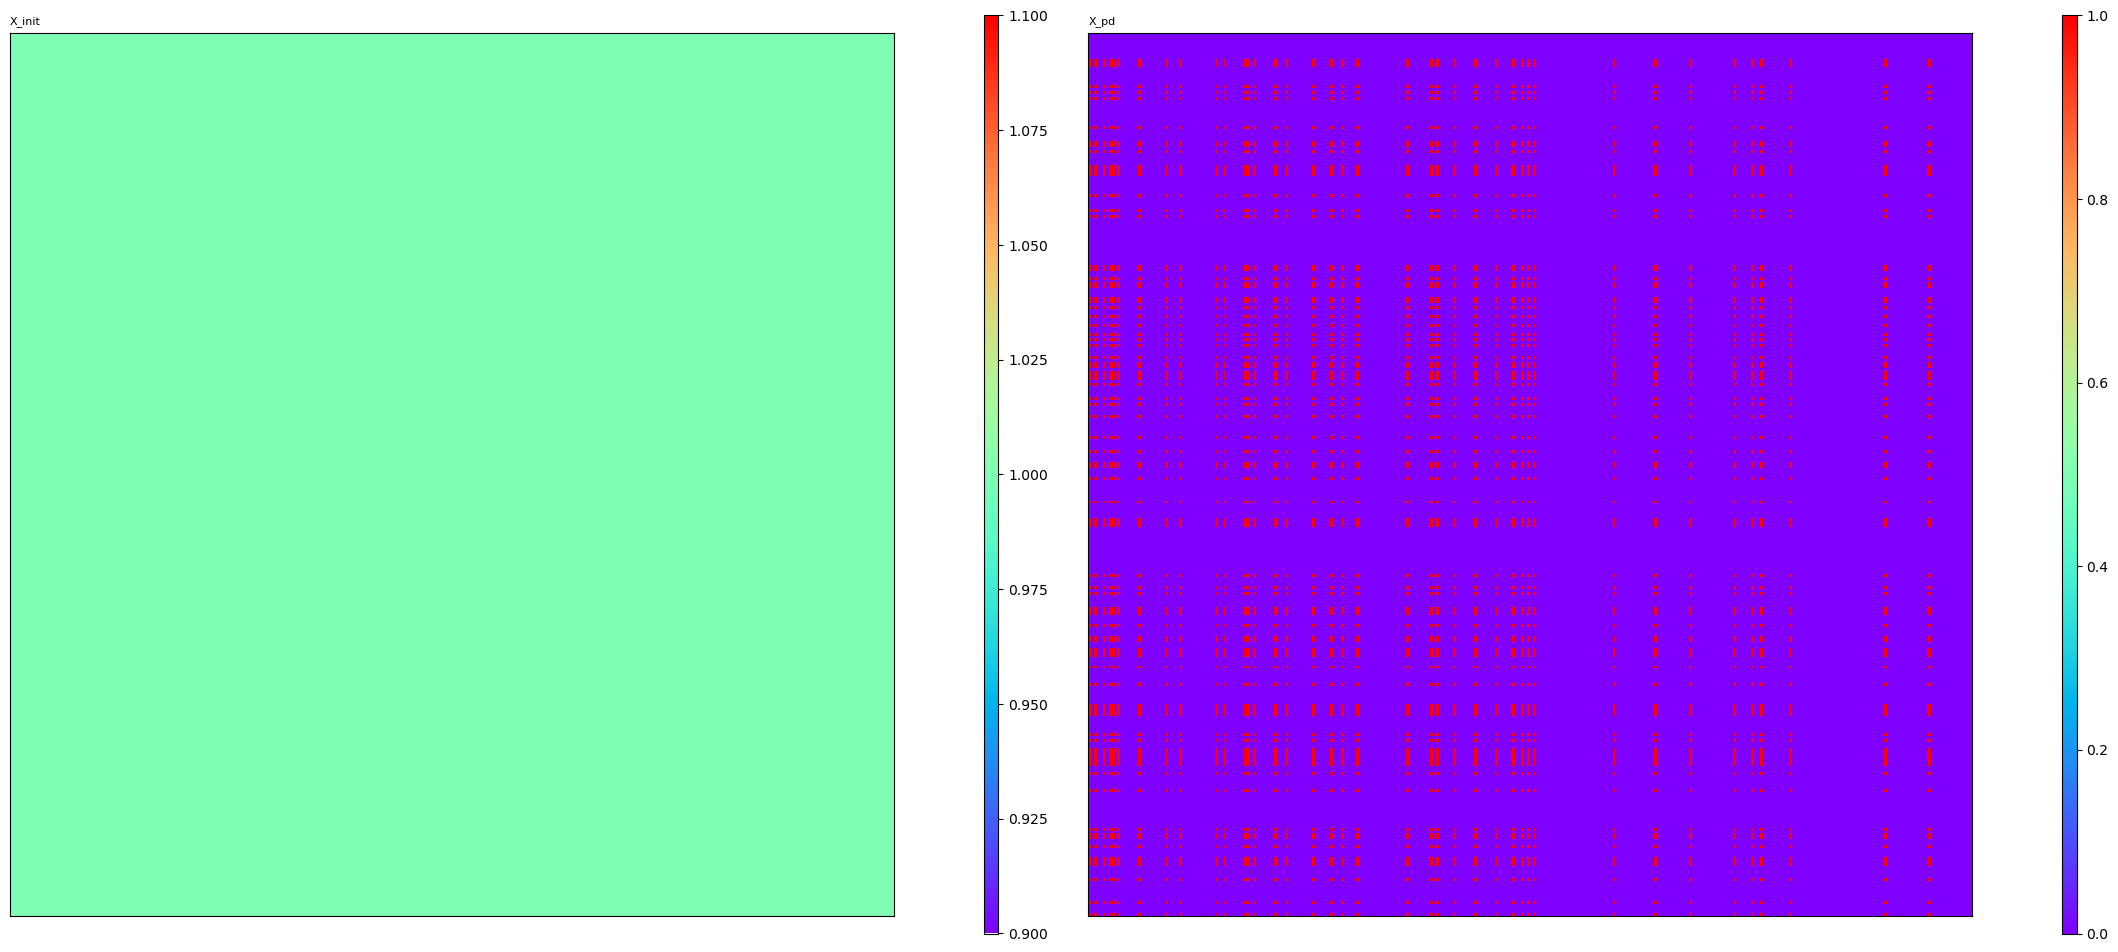

<Figure size 640x480 with 0 Axes>

In [10]:
# from ELBMFNumPy import ELBMF, _rounding, _print_loss, _product
# from utils import show_matrix

# k = 150
# l1reg = 0.000005
# l2reg = 0.9
# c = 1.05
# maxiter = 1000
# tolerance = 0.001
# beta = 0.0 # if beta > 0 -> use iPALM else use PALM
# random_seed = 1000

# model = ELBMF(org_A, A, k, l1reg, l2reg, c, maxiter, tolerance, random_seed, beta)

# U_init = _rounding(model.U.copy())
# V_init = _rounding(model.V.copy())
# X_init = _product(U_init, V_init)

# model.factorize()

# U_init = _rounding(model.U.copy())
# V_init = _rounding(model.V.copy())
# X_pd = _product(U_init, V_init)
# show_matrix([(X_init, [0, 0], 'X_init'), (X_pd, [0, 1], 'X_pd')], colorbar=True)

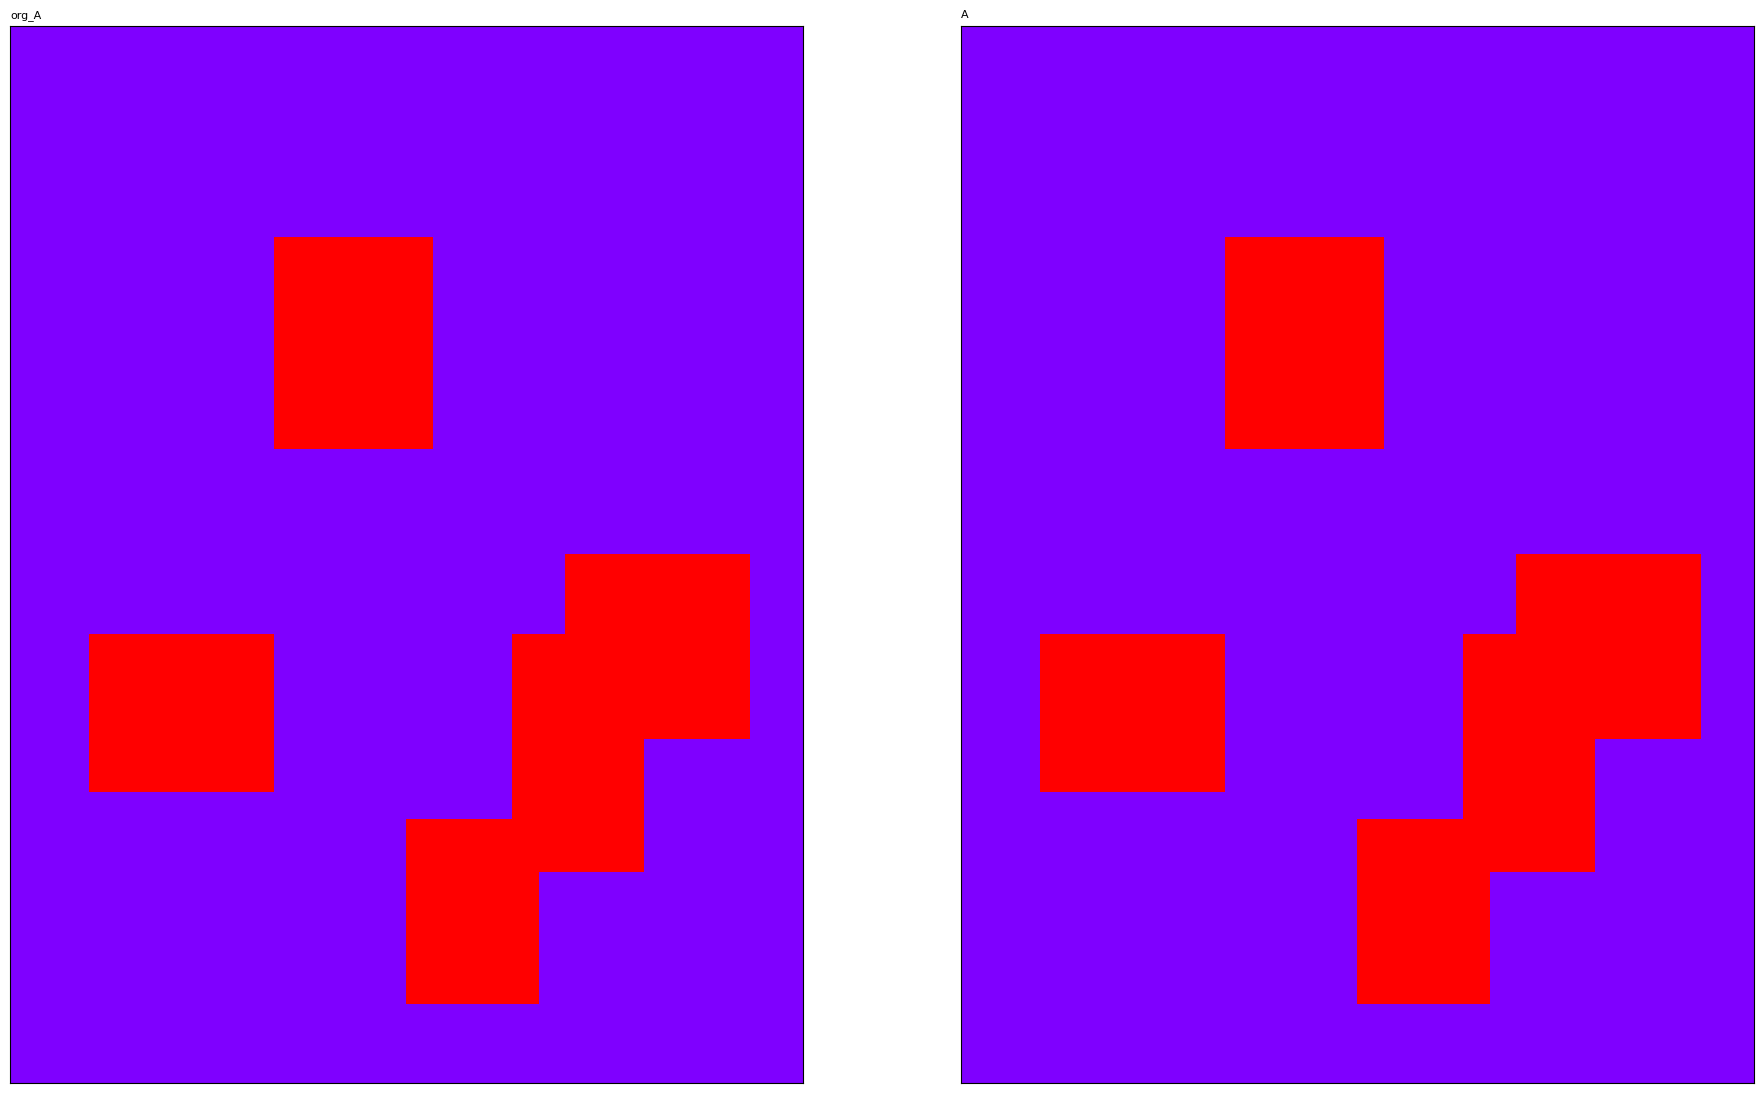

<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np

random_seed = 19
np.random.seed(random_seed)

are_itersecting = lambda s, t: not (s['min_x'] > t['max_x'] | s['max_x'] < t['min_x'] | s['min_y'] > t['max_y'] | s['max_y'] < t['min_y'])

perturb = lambda x, pflip:((x != 0) ^ (np.rand() <= pflip))

def random_tile(n, m, min_width, max_width, min_height, max_height):
    x = np.random.randint(1, n)
    y = np.random.randint(1, m)
    w = np.random.randint(min_width, max_width)
    h = np.random.randint(min_height, max_height)
    return {'min_x':x, 'max_x':min(n, x + w), 'min_y':y, 'max_y':min(m, y + h)}

def generate_tiles(n, m, num_tiles, tile_width_range, tile_height_range, max_trials = 10, allow_overlap = True):
    tiles = []
    trials = 0
    while (len(tiles) < num_tiles) and (trials < max_trials):
        t = random_tile(n - 1, m - 1, tile_width_range[0], tile_width_range[1], tile_height_range[0], tile_height_range[1])
        if (allow_overlap or not any([are_itersecting(s, t) for s in tiles])):
            tiles.append(t)
            trials = 0
        else:
            trials = trials + 1
    return tiles

def generate_tiled_random_matrix(n, m, k, area_boundaries, noise, allow_overlap = True):
    tiles = generate_tiles(n, m, k, area_boundaries, area_boundaries, allow_overlap = allow_overlap)
    A = np.zeros((n, m))
    for t in tiles:
        A[t['min_x']:t['max_x'], t['min_y']:t['max_y']] = 1
    add_noise = lambda x, pflip: ((x != 0) | (np.random.rand() <= pflip))
    B = add_noise(A, noise)
    return B.astype(A.dtype), A

opts = {}

opts["n"] = 40
opts["m"] = 30
opts["k"] = 5
opts["minwidth"] = 5
opts["maxwidth"] = 10
opts["additivenoise"] = 0.05
opts["allowoverlap"] = True


A, org_A = generate_tiled_random_matrix(
        opts["n"],
        opts["m"],
        opts["k"],
        (opts["minwidth"], opts["maxwidth"]),
        opts["additivenoise"],
        allow_overlap = opts["allowoverlap"]
        )

from utils import show_matrix

show_matrix([(org_A, [0, 0], 'org_A'), (A, [0, 1], 'A')])

In [3]:
# from utils import show_matrix, to_dense

# org_A = to_dense(X_train)
# A = to_dense(X_train)


# show_matrix([(org_A, [0, 0], 'org_A'), (A, [0, 1], 'A')])

NameError: name 'X_train' is not defined

init_loss
recall : 0.7365853658536585, similarity : 0.6441666666666667, relative loss : 158465.0
init_loss
recall : 0.7365853658536585, similarity : 0.6441666666666667, relative loss : 158465.0


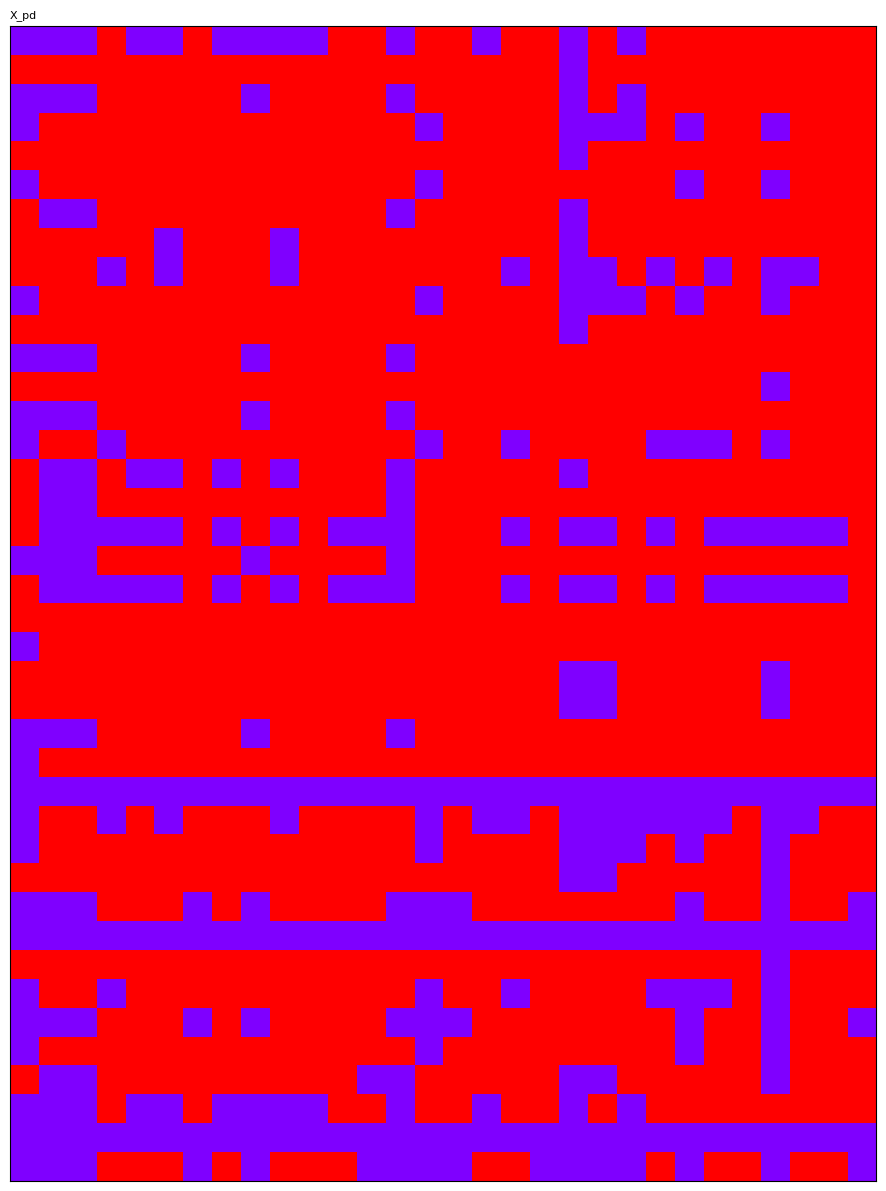

result_loss
recall : 0.8975609756097561, similarity : 0.0175, relative loss : 4305.0
init_loss
recall : 0.8975609756097561, similarity : 0.0175, relative loss : 4305.0


<Figure size 640x480 with 0 Axes>

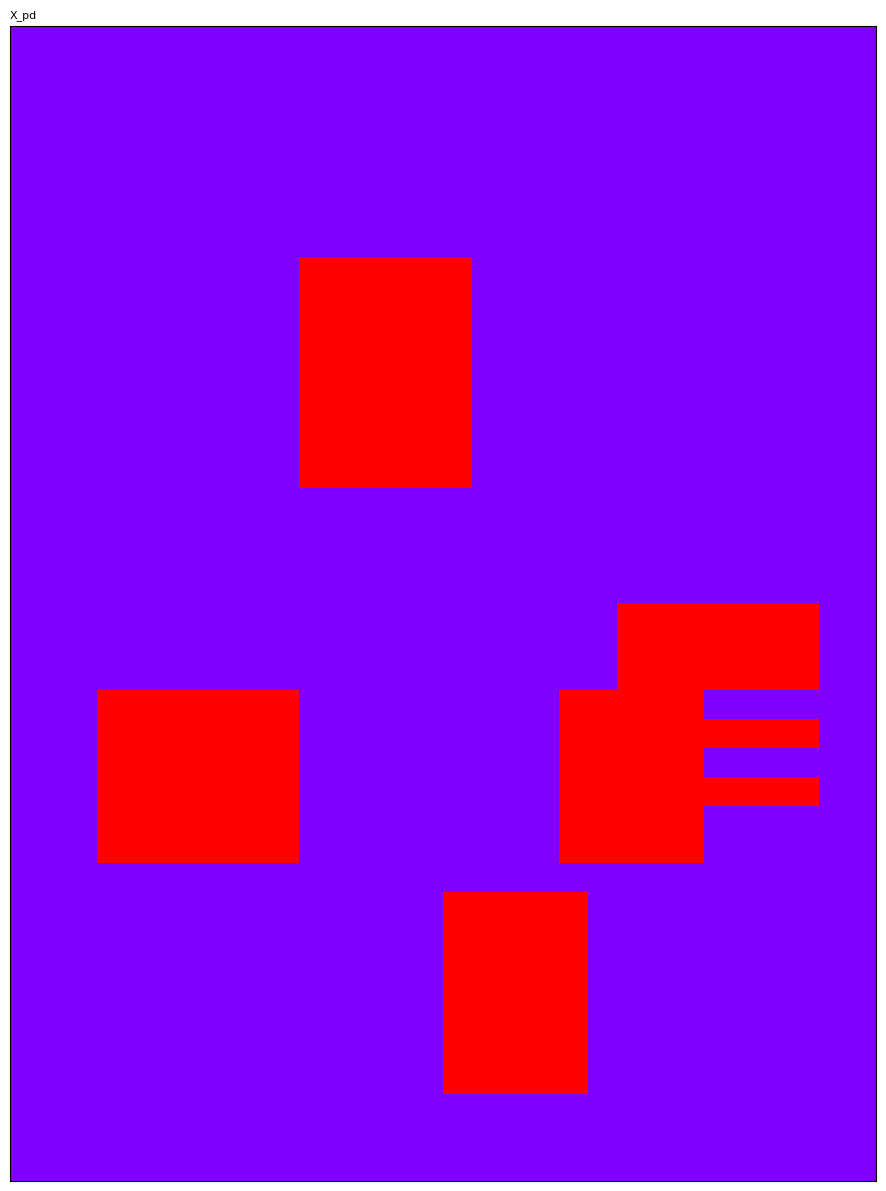

<Figure size 640x480 with 0 Axes>

In [6]:
from ELBMFNumPy import ELBMF, _rounding, _print_loss, _product
from utils import show_matrix

k = 5
l1reg = 0.5
l2reg = 0.9
c = 1.05
maxiter = 100
tolerance = 0.001
beta = 0.0 # if beta > 0 -> use iPALM else use PALM

model = ELBMF(org_A, A, k, l1reg, l2reg, c, maxiter, tolerance, random_seed, beta)

U_init = _rounding(model.U.copy())
V_init = _rounding(model.V.copy())
print('init_loss')
_print_loss(org_A, U_init, V_init)
X_pd = _product(U_init, V_init)
show_matrix([(X_pd, [0, 0], 'X_pd')])

model.factorize()

U_init = _rounding(model.U.copy())
V_init = _rounding(model.V.copy())
print('init_loss')
_print_loss(org_A, U_init, V_init)
X_pd = _product(U_init, V_init)
show_matrix([(X_pd, [0, 0], 'X_pd')])

In [ ]:
from elbmf import _rounding

X = np.array([[0.8]])
_rounding(X)

array([[1.]])

[I] k            : 100
[I] U            : None
[I] V            : None
[I] init_method  : uniform
[I] reg_l1       : 0
[I] reg_l2       : 0.02
[I] reg_growth   : 1.0002
[I] max_iter     : 5000
[I] min_diff     : 1e-08
[I] beta         : 0
[I] seed         : 1720782407
[I] verbose      : False
[I] display      : False
[I] task         : reconstruction
[I] Missing validation data.
[W] Missing testing data.
[I] U, V existed. Skipping initialization.
torch.Size([300, 500]) <class 'torch.Tensor'>
100
None
None
0
0.02
<function ELBMF._fit.<locals>.<lambda> at 0x0000020F5CD11280>
5000
1e-08
0
None
True
1720782407


[I] error: 1889.6002, U: [0.0000, 3.5503], V: [0.0000, 3.7823]: 100%|██████████| 5000/5000 [00:43<00:00, 114.33it/s]


[W] Timer not started.
[I] model saved as: 24-07-12_19-07-31_ELBMF.pickle


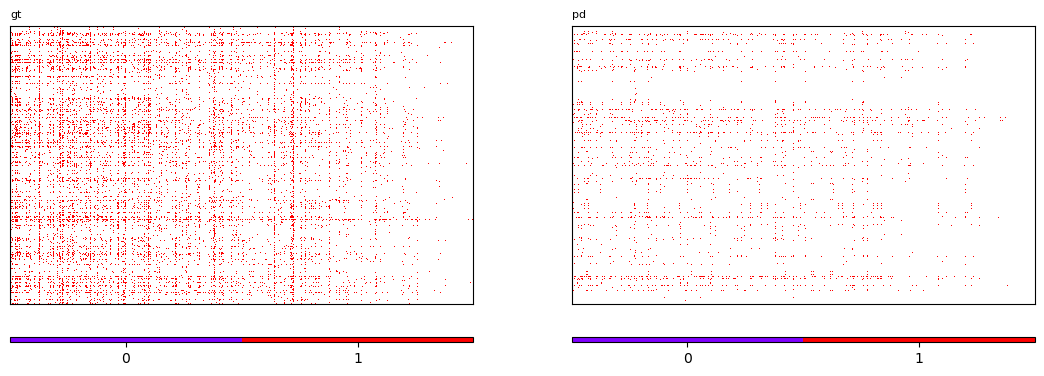

train                             
                             0                             
                time    Recall Precision Accuracy        F1
0  12/07/24 07:07:31  0.229031  0.926288  0.94342  0.367256

<Figure size 640x480 with 0 Axes>

In [ ]:
# from models import ELBMF

# k = 100
# reg_l1 = 0#0.01
# reg_l2 = 0.02
# reg_growth = 1.0002
# max_iter = 5000
# min_diff = 1e-8
# beta = 0 # 0.0001
# seed = None
# task = 'reconstruction'

# U, V, init_method = None, None, 'uniform'
# # U, V, init_method = model_nmf.U.copy(), model_nmf.V.copy(), 'custom'

# model = ELBMF(k=k, U=U, V=V, init_method=init_method, reg_l1=reg_l1, reg_l2=reg_l2, reg_growth=reg_growth, max_iter=max_iter, min_diff=min_diff, beta=beta, seed=seed)
# model.fit(X_train=X_train, task=task)

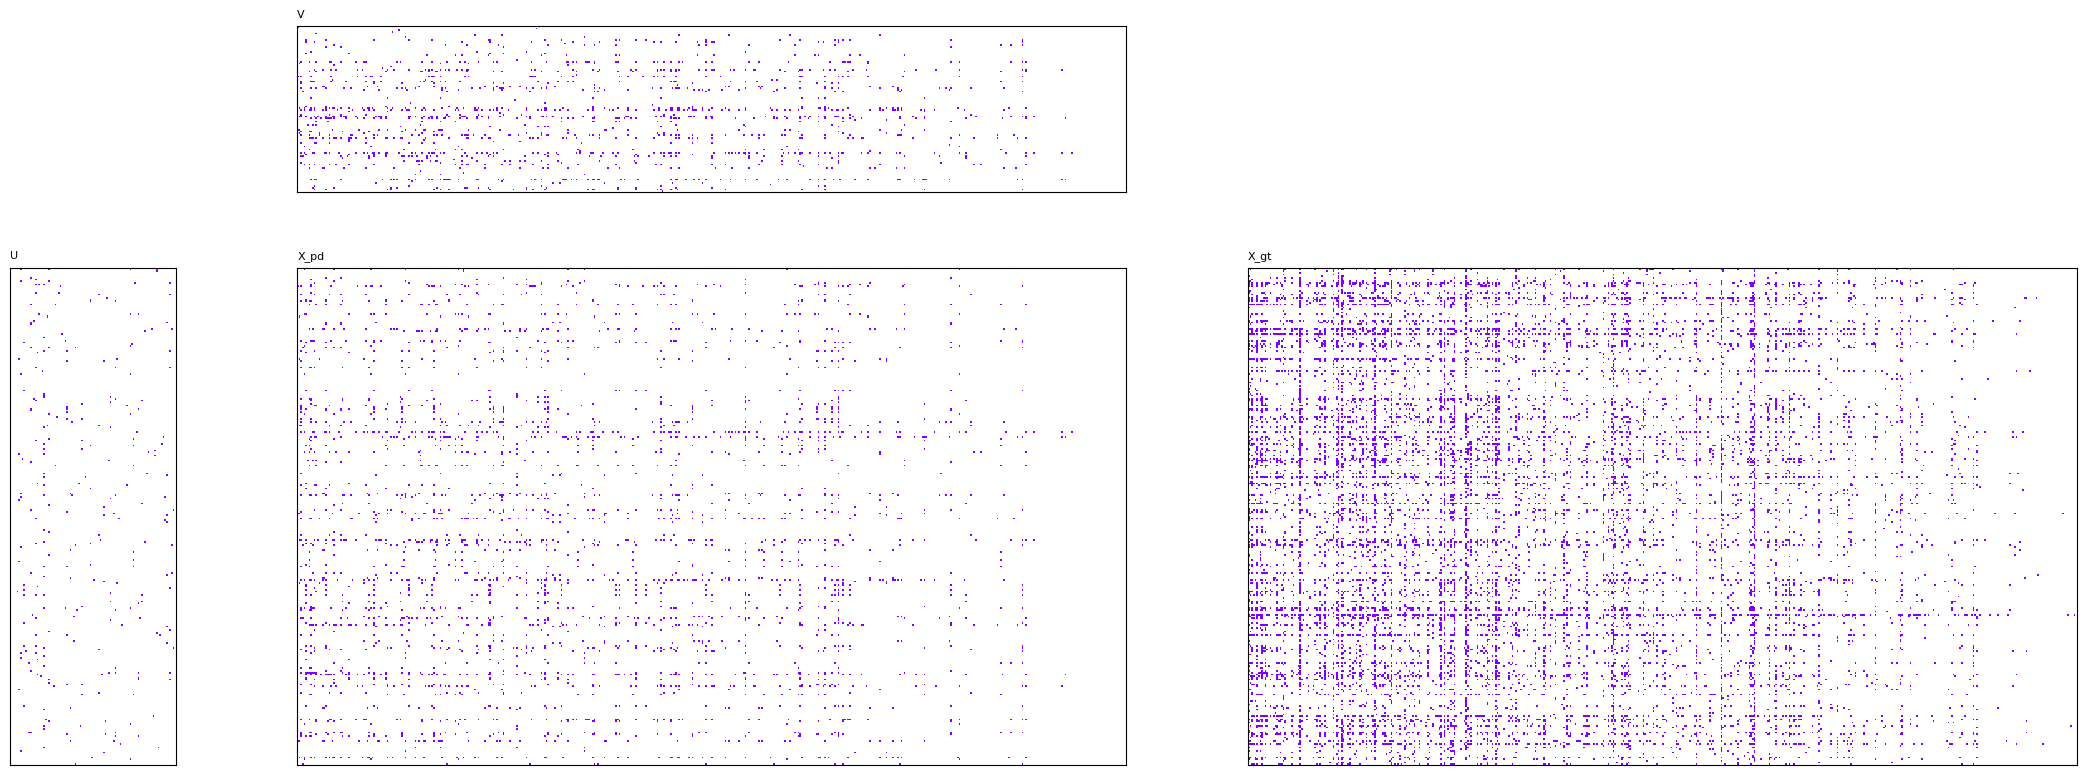

<Figure size 640x480 with 0 Axes>

In [ ]:
# import numpy as np
# import torch
# from models.ELBMF import elbmf

# X = np.array(X_train.toarray(), dtype=np.float64)
# X = torch.from_numpy(X).float()

# import torch
# from models import ELBMF

# U, V = elbmf(
#     X                   = X,                  # a Boolean n*m matrix  
#     n_components        = 100,                 # number of components
#     l1reg               = 0.001,               # l1 coefficient
#     l2reg               = 0.002,               # l2 coefficient
#     regularization_rate = lambda t: 1.0025**t,  # monotonically increasing regularization-rate function
#     maxiter             = 10000,               # maximum number of iterations
#     tolerance           = 1e-8,               # the threshold to the absolute difference between the current and previous losses determines the convergence
#     beta                = 0.0,             # inertial coefficient of iPALM
#     callback            = None,               # e.g. lambda t, U, V, fn: print(t, fn)
#     with_rounding       = True)               # rounds U and V in case of early stopping



# from utils import show_matrix, matmul
# from scipy.sparse import csr_matrix

# U_sparse, V_sparse = csr_matrix(U), csr_matrix(V)
# X_sparse = matmul(U_sparse, V_sparse, boolean=True, sparse=True)
# X_original = csr_matrix(X)

# show_matrix([(U_sparse, [1, 0], 'U'), (V_sparse, [0, 1], 'V'), (X_sparse, [1, 1], 'X_pd'), (X_original, [1, 2], 'X_gt')])